In [42]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
raw_data = pd.read_csv('FIFA_raw_data.csv')
df = raw_data.copy()
df = df.drop(['ID', 'LongName', 'photoUrl', 'playerUrl'], axis = 1)
df = df.rename(columns={'↓OVA':'OVA'})
df["Club"]=df["Club"].str.strip("\n\n\n\n")
df['Height'] = df['Height'].str.replace('cm', '')
def ft_to_cm(x):
    if "'" in x:
        parts = x.replace('"', '').split("'")
        feet = float(parts[0])
        inches = float(parts[1]) if parts[1] else 0
        cm = round((feet * 30.48) + (inches * 2.54), 0)
        return int(cm)
    else:
        return int(x)

df["Height"]=df["Height"].apply(ft_to_cm)
df["Height"].unique()
df['Weight'] = df['Weight'].str.replace('kg', '')
def lbs_to_kg(x):
    if "lbs" in x:
        lbs = x.replace("lbs", "")
        kg = round(int(lbs) / 2.2, 0)
        return int(kg)
    else:
        return int(x)

df['Weight'] = df['Weight'].apply(lbs_to_kg)
df.rename(columns={'Height':'Height(cm)','Weight':'Weight(kg)'},inplace =True)
def money(x):
    if "€" in x:
        x = x.replace("€", "")
    if "M" in x:
        x=x.replace("M", "")
        return int(float(x) * 1000000)
    elif "K" in x:
        x = x.replace("K", "")
        return int(float(x) * 1000)

    return int(x)

df['Value'] = df['Value'].apply(money)
df['Wage'] = df['Wage'].apply(money)
df['Release Clause'] = df['Release Clause'].apply(money)

df.rename(columns = {'Value':'Value (€)', "Wage":"Wage (€)"})

df['W/F'] = df['W/F'].str.replace("★", "")
df['SM'] = df['SM'].str.replace("★", "")
df['IR'] = df['IR'].str.replace("★", "")

df.rename(columns = {'W/F':'Weak Foot /5', "SM":"Skill Moves /5", "IR": "International Reputation /5"}, inplace = True)

def type(x):
    if "Free" in x:
        return "Free"
    if "Loan" in x:
        return "Loan"
    if "~" in x:
        return "Contract"
    else:
        return pd.NA

def start_time_contract(x):
    if "~" in x:
        return  int(x[:4])
    if "Loan" in x:
        x=x.strip(" On Loan")
        x= datetime.strptime(x, "%b %d, %Y")
        return x.date()
    else:
        return pd.NA

def end_time_contract(type,contract,loan):
    if type == "Contract":
        return int(contract[-4:])
    if type == "Loan":
        loan = datetime.strptime(loan, "%b %d, %Y")
        return loan.date()

    else:
        return pd.NA

df["Type of contract"] = df["Contract"].apply(type)
df["Start year"] = df["Contract"].apply(start_time_contract)
df["End year"] = df.apply(lambda row: end_time_contract(row["Type of contract"],row["Contract"],row["Loan Date End"] ), axis=1)

df["Attacking"]=round(df["Attacking"]/5,0)
df["Attacking"]=df["Attacking"].astype("int64")

df["Skill"]=df["Skill"]/5
df["Skill"]=df["Skill"].astype("int64")


df["Movement"]=df["Movement"]/5
df["Movement"]=df["Movement"].astype("int64")


df["Power"]=df["Power"]/5
df["Power"]=df["Power"].astype("int64")


df["Mentality"]=df["Mentality"]/6
df["Mentality"]=df["Mentality"].astype("int64")

df["Defending"]=df["Defending"]/3
df["Defending"]=df["Defending"].astype("int64")

df["Goalkeeping"] = df["Goalkeeping"]/5
df["Goalkeeping"] = df["Goalkeeping"].astype("int64")

df=df.rename(columns={"Attacking":"Attacking AVG", "Skill":"Skill AVG", "Movement":"Movement AVG",
                    "Power":"Power AVG", "Mentality":"Mentality AVG", "Defending":"Defending AVG", "Goalkeeping":"Goalkeeping AVG"} )

df = df.drop(['Hits'], axis=1)

df_columns = ['Name', 'Nationality', 'Age', 'OVA', 'POT', 'Club', 'Contract',
       'Positions', 'Height(cm)', 'Weight(kg)', 'Preferred Foot', 'BOV',
       'Best Position', 'Joined','Type of contract', 'Start year',
       'End year', 'Loan Date End', 'Value', 'Wage',
       'Release Clause', 'Attacking AVG', 'Crossing', 'Finishing',
       'Heading Accuracy', 'Short Passing', 'Volleys', 'Skill AVG',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
       'Movement AVG', 'Acceleration', 'Sprint Speed', 'Agility', 'Reactions',
       'Balance', 'Power AVG', 'Shot Power', 'Jumping', 'Stamina', 'Strength',
       'Long Shots', 'Mentality AVG', 'Aggression', 'Interceptions',
       'Positioning', 'Vision', 'Penalties', 'Composure', 'Defending AVG',
       'Marking', 'Standing Tackle', 'Sliding Tackle', 'Goalkeeping AVG',
       'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
       'GK Reflexes', 'Total Stats', 'Base Stats', 'Weak Foot /5',
       'Skill Moves /5', 'A/W', 'D/W', 'International Reputation /5', 'PAC',
       'SHO', 'PAS', 'DRI', 'DEF', 'PHY',]

df=df[df_columns]

df=df.drop(columns=['Loan Date End','Joined'])

df[['Weak Foot /5', 'Skill Moves /5', 'International Reputation /5']] = df[['Weak Foot /5', 'Skill Moves /5', 'International Reputation /5']]\
.apply(pd.to_numeric)

def find_field_position(x):
    if x == 'GK':
        return x
    elif x in ['CB', 'RB', 'LB', 'LWB', 'RWB']:
        return 'DEF'
    elif x in ['CAM', 'CDM', 'CM', 'LM', 'RM']:
        return 'MID'
    else:
        return 'ATT'

df['Field Position'] = df['Best Position'].apply(find_field_position)

col_names = ['Name', 'Nationality', 'Age', 'OVA', 'POT', 'Club', 'Contract',
       'Positions', 'Height(cm)', 'Weight(kg)', 'Preferred Foot', 'BOV',
       'Best Position', 'Field Position', 'Type of contract', 'Start year', 'End year', 'Value',
       'Wage', 'Release Clause', 'Attacking AVG', 'Crossing', 'Finishing',
       'Heading Accuracy', 'Short Passing', 'Volleys', 'Skill AVG',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
       'Movement AVG', 'Acceleration', 'Sprint Speed', 'Agility', 'Reactions',
       'Balance', 'Power AVG', 'Shot Power', 'Jumping', 'Stamina', 'Strength',
       'Long Shots', 'Mentality AVG', 'Aggression', 'Interceptions',
       'Positioning', 'Vision', 'Penalties', 'Composure', 'Defending AVG',
       'Marking', 'Standing Tackle', 'Sliding Tackle', 'Goalkeeping AVG',
       'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
       'GK Reflexes', 'Total Stats', 'Base Stats', 'Weak Foot /5',
       'Skill Moves /5', 'A/W', 'D/W', 'International Reputation /5', 'PAC',
       'SHO', 'PAS', 'DRI', 'DEF', 'PHY']

df = df[col_names]

df_preprocessed = df.copy()

C:\Users\Ben\AppData\Local\Temp\ipykernel_15096\4156665647.py:6: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('FIFA_raw_data.csv')


# Adding the area of play column

What I want is to add an area of play column that shows if a player is a defender, midfielder, attacker etc.

Make a loop, use apply? df['Field Position'] = etc.

HAS NOW BEEN ADDED TO THE MASTER, NO NEED TO RERUN

In [45]:
df['Best Position'].unique()

array(['RW', 'ST', 'GK', 'CAM', 'LW', 'CB', 'CDM', 'CF', 'CM', 'RB', 'LB',
       'LM', 'RM', 'LWB', 'RWB'], dtype=object)

In [47]:
def find_field_position(x):
    if x == 'GK':
        return x
    elif x in ['CB', 'RB', 'LB', 'LWB', 'RWB']:
        return 'DEF'
    elif x in ['CAM', 'CDM', 'CM', 'LM', 'RM']:
        return 'MID'
    else:
        return 'ATT'

# I hope I got it right...

In [49]:
df['Field Position'] = df['Best Position'].apply(find_field_position)

In [51]:
df['Field Position']

0        ATT
1        ATT
2         GK
3        MID
4        ATT
        ... 
18974    DEF
18975    MID
18976    MID
18977    ATT
18978    DEF
Name: Field Position, Length: 18979, dtype: object

In [53]:
df.head()

,Name,Nationality,Age,OVA,POT,Club,Contract,Positions,Height(cm),Weight(kg),...,A/W,D/W,International Reputation /5,PAC,SHO,PAS,DRI,DEF,PHY,Field Position
0,L. Messi,Argentina,33,93,93,FC Barcelona,2004 ~ 2021,"RW, ST, CF",170,72,...,Medium,Low,5,85,92,91,95,38,65,ATT
1,Cristiano Ronaldo,Portugal,35,92,92,Juventus,2018 ~ 2022,"ST, LW",187,83,...,High,Low,5,89,93,81,89,35,77,ATT
2,J. Oblak,Slovenia,27,91,93,Atlético Madrid,2014 ~ 2023,GK,188,87,...,Medium,Medium,3,87,92,78,90,52,90,GK
3,K. De Bruyne,Belgium,29,91,91,Manchester City,2015 ~ 2023,"CAM, CM",181,70,...,High,High,4,76,86,93,88,64,78,MID
4,Neymar Jr,Brazil,28,91,91,Paris Saint-Germain,2017 ~ 2022,"LW, CAM",175,68,...,High,Medium,5,91,85,86,94,36,59,ATT


In [55]:
df.columns

Index(['Name', 'Nationality', 'Age', 'OVA', 'POT', 'Club', 'Contract',
       'Positions', 'Height(cm)', 'Weight(kg)', 'Preferred Foot', 'BOV',
       'Best Position', 'Type of contract', 'Start year', 'End year', 'Value',
       'Wage', 'Release Clause', 'Attacking AVG', 'Crossing', 'Finishing',
       'Heading Accuracy', 'Short Passing', 'Volleys', 'Skill AVG',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
       'Movement AVG', 'Acceleration', 'Sprint Speed', 'Agility', 'Reactions',
       'Balance', 'Power AVG', 'Shot Power', 'Jumping', 'Stamina', 'Strength',
       'Long Shots', 'Mentality AVG', 'Aggression', 'Interceptions',
       'Positioning', 'Vision', 'Penalties', 'Composure', 'Defending AVG',
       'Marking', 'Standing Tackle', 'Sliding Tackle', 'Goalkeeping AVG',
       'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
       'GK Reflexes', 'Total Stats', 'Base Stats', 'Weak Foot /5',
       'Skill Moves /5', 'A/W', 'D/W', 'Internat

In [57]:
col_names = ['Name', 'Nationality', 'Age', 'OVA', 'POT', 'Club', 'Contract',
       'Positions', 'Height(cm)', 'Weight(kg)', 'Preferred Foot', 'BOV',
       'Best Position', 'Field Position', 'Type of contract', 'Start year', 'End year', 'Value',
       'Wage', 'Release Clause', 'Attacking AVG', 'Crossing', 'Finishing',
       'Heading Accuracy', 'Short Passing', 'Volleys', 'Skill AVG',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
       'Movement AVG', 'Acceleration', 'Sprint Speed', 'Agility', 'Reactions',
       'Balance', 'Power AVG', 'Shot Power', 'Jumping', 'Stamina', 'Strength',
       'Long Shots', 'Mentality AVG', 'Aggression', 'Interceptions',
       'Positioning', 'Vision', 'Penalties', 'Composure', 'Defending AVG',
       'Marking', 'Standing Tackle', 'Sliding Tackle', 'Goalkeeping AVG',
       'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
       'GK Reflexes', 'Total Stats', 'Base Stats', 'Weak Foot /5',
       'Skill Moves /5', 'A/W', 'D/W', 'International Reputation /5', 'PAC',
       'SHO', 'PAS', 'DRI', 'DEF', 'PHY']

In [59]:
df = df[col_names]

In [61]:
df[['Best Position', 'Field Position']].head(20)

,Best Position,Field Position
0,RW,ATT
1,ST,ATT
2,GK,GK
3,CAM,MID
4,LW,ATT
5,ST,ATT
6,RW,ATT
7,GK,GK
8,ST,ATT
9,GK,GK


# Exploratory Analysis

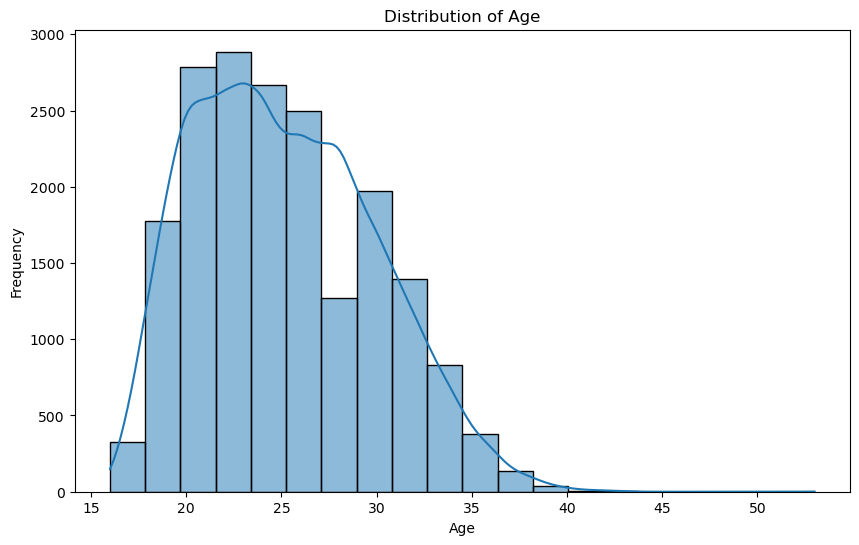

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

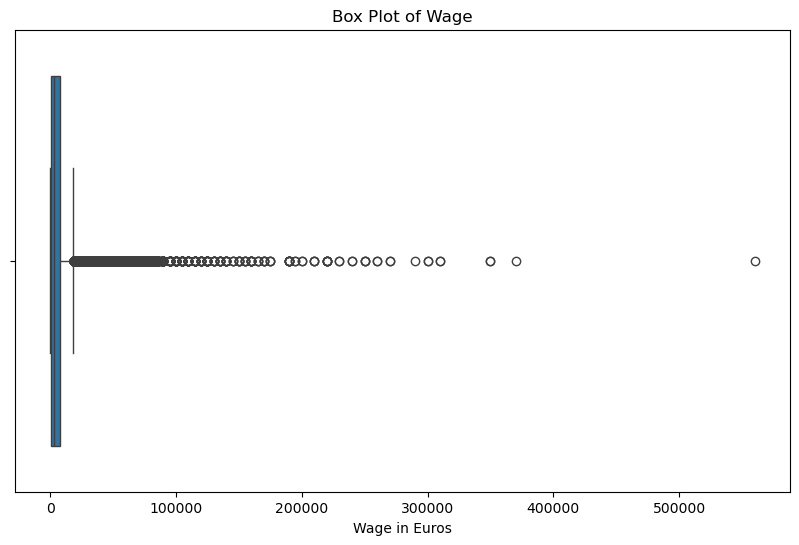

In [7]:
# Boxplot of Wage
plt.figure(figsize=(10, 6))
sns.boxplot(x='Wage', data=df)
plt.title('Box Plot of Wage')
plt.xlabel('Wage in Euros')
plt.show()

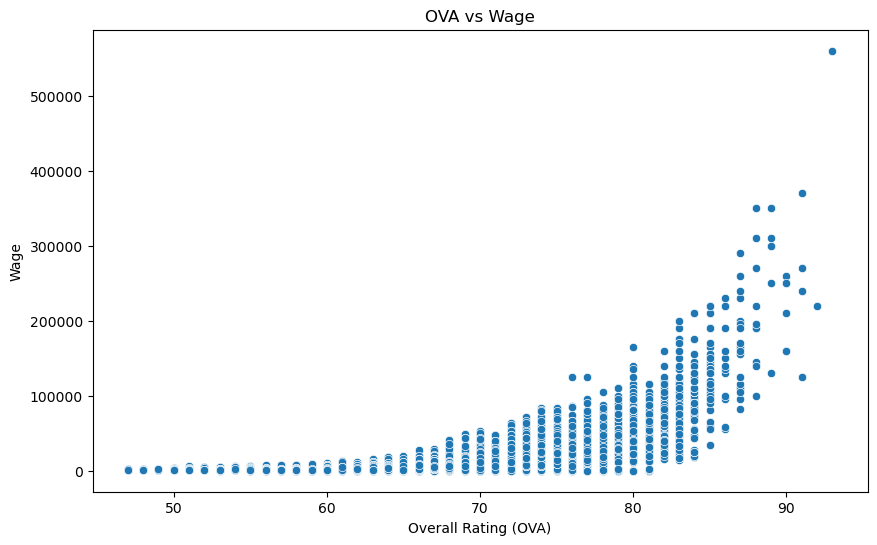

In [5]:
#Scatter Plot of Overall vs Wage

plt.figure(figsize=(10, 6))
sns.scatterplot(x='OVA', y='Wage', data=df)
plt.title('OVA vs Wage')
plt.xlabel('Overall Rating (OVA)')
plt.ylabel('Wage')
plt.show()

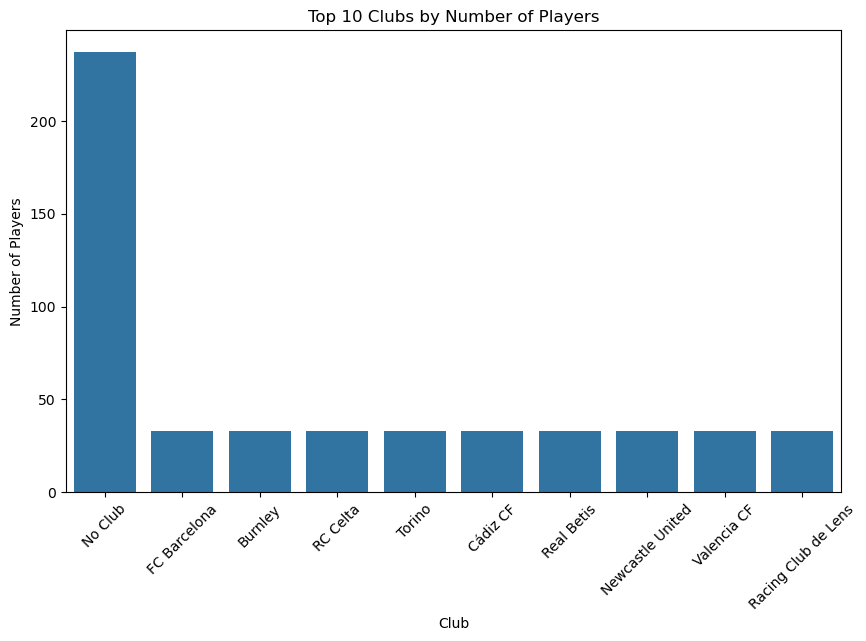

In [71]:
club_counts = df['Club'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=club_counts.index, y=club_counts.values)
plt.xticks(rotation=45)
plt.title('Top 10 Clubs by Number of Players')
plt.xlabel('Club')
plt.ylabel('Number of Players')
plt.show()

Text(0.5, 1.0, 'Player Potential vs Age')

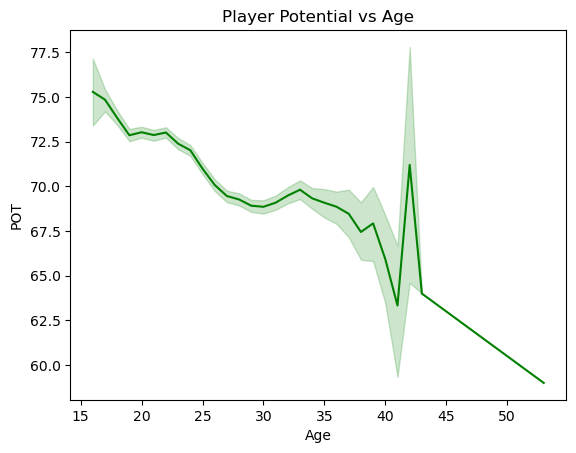

In [9]:
sns.lineplot(x=df['Age'],y=df['POT'],color='green')
plt.title('Player Potential vs Age')

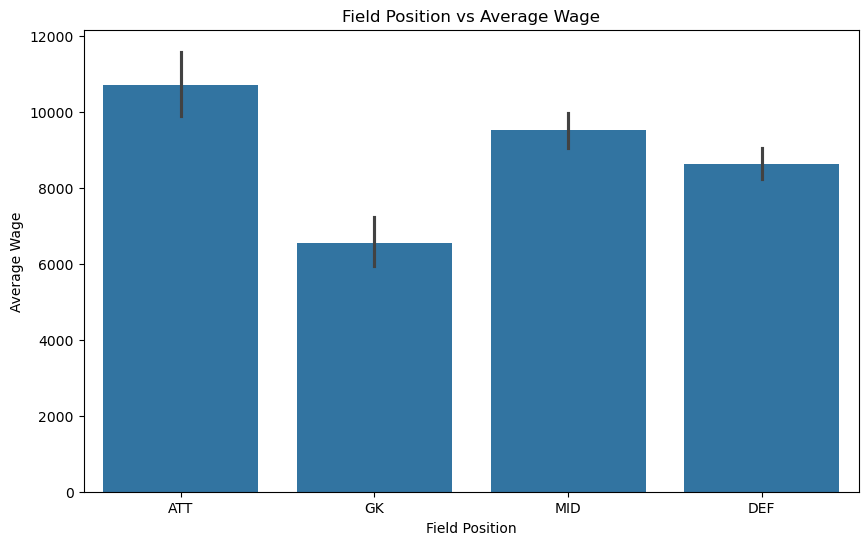

In [67]:
# MY one all of my own of wage vs field position

plt.figure(figsize=(10, 6))
sns.barplot(x='Field Position', y='Wage', data=df)
plt.title('Field Position vs Average Wage')
plt.xlabel('Field Position')
plt.ylabel('Average Wage')
plt.show()

In [75]:
position_in_order = ["GK", "LWB", "LB", "CB", "RB", "RWB", "CDM", "LM", "CM", "RM", "CAM", "LW", "CF", "RW", "ST"]

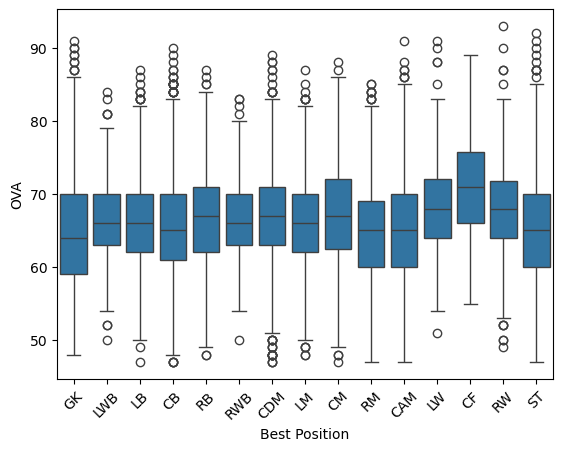

In [77]:
plt.xticks(rotation=45)
sns.boxplot(data=df,x="Best Position",y="OVA",order=position_in_order)
plt.show()

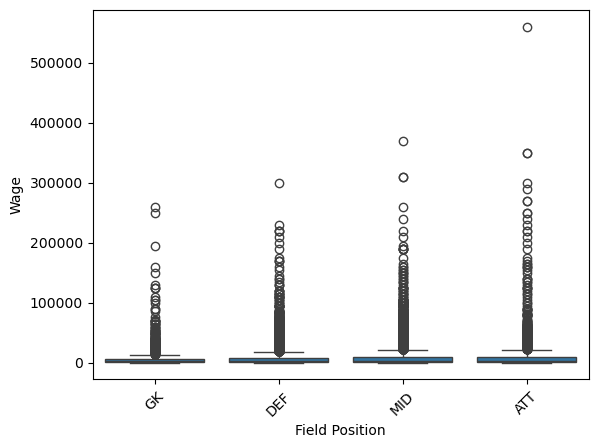

In [81]:
field_positions_in_order = ['GK', 'DEF', 'MID', 'ATT']
plt.xticks(rotation=45)
sns.boxplot(data=df,x="Field Position",y="Wage",order=field_positions_in_order)
plt.show()

#Ends up being a terribly useless graph as... well, most players get paid incredibly low compared to the outliers!

# Outlier Detection

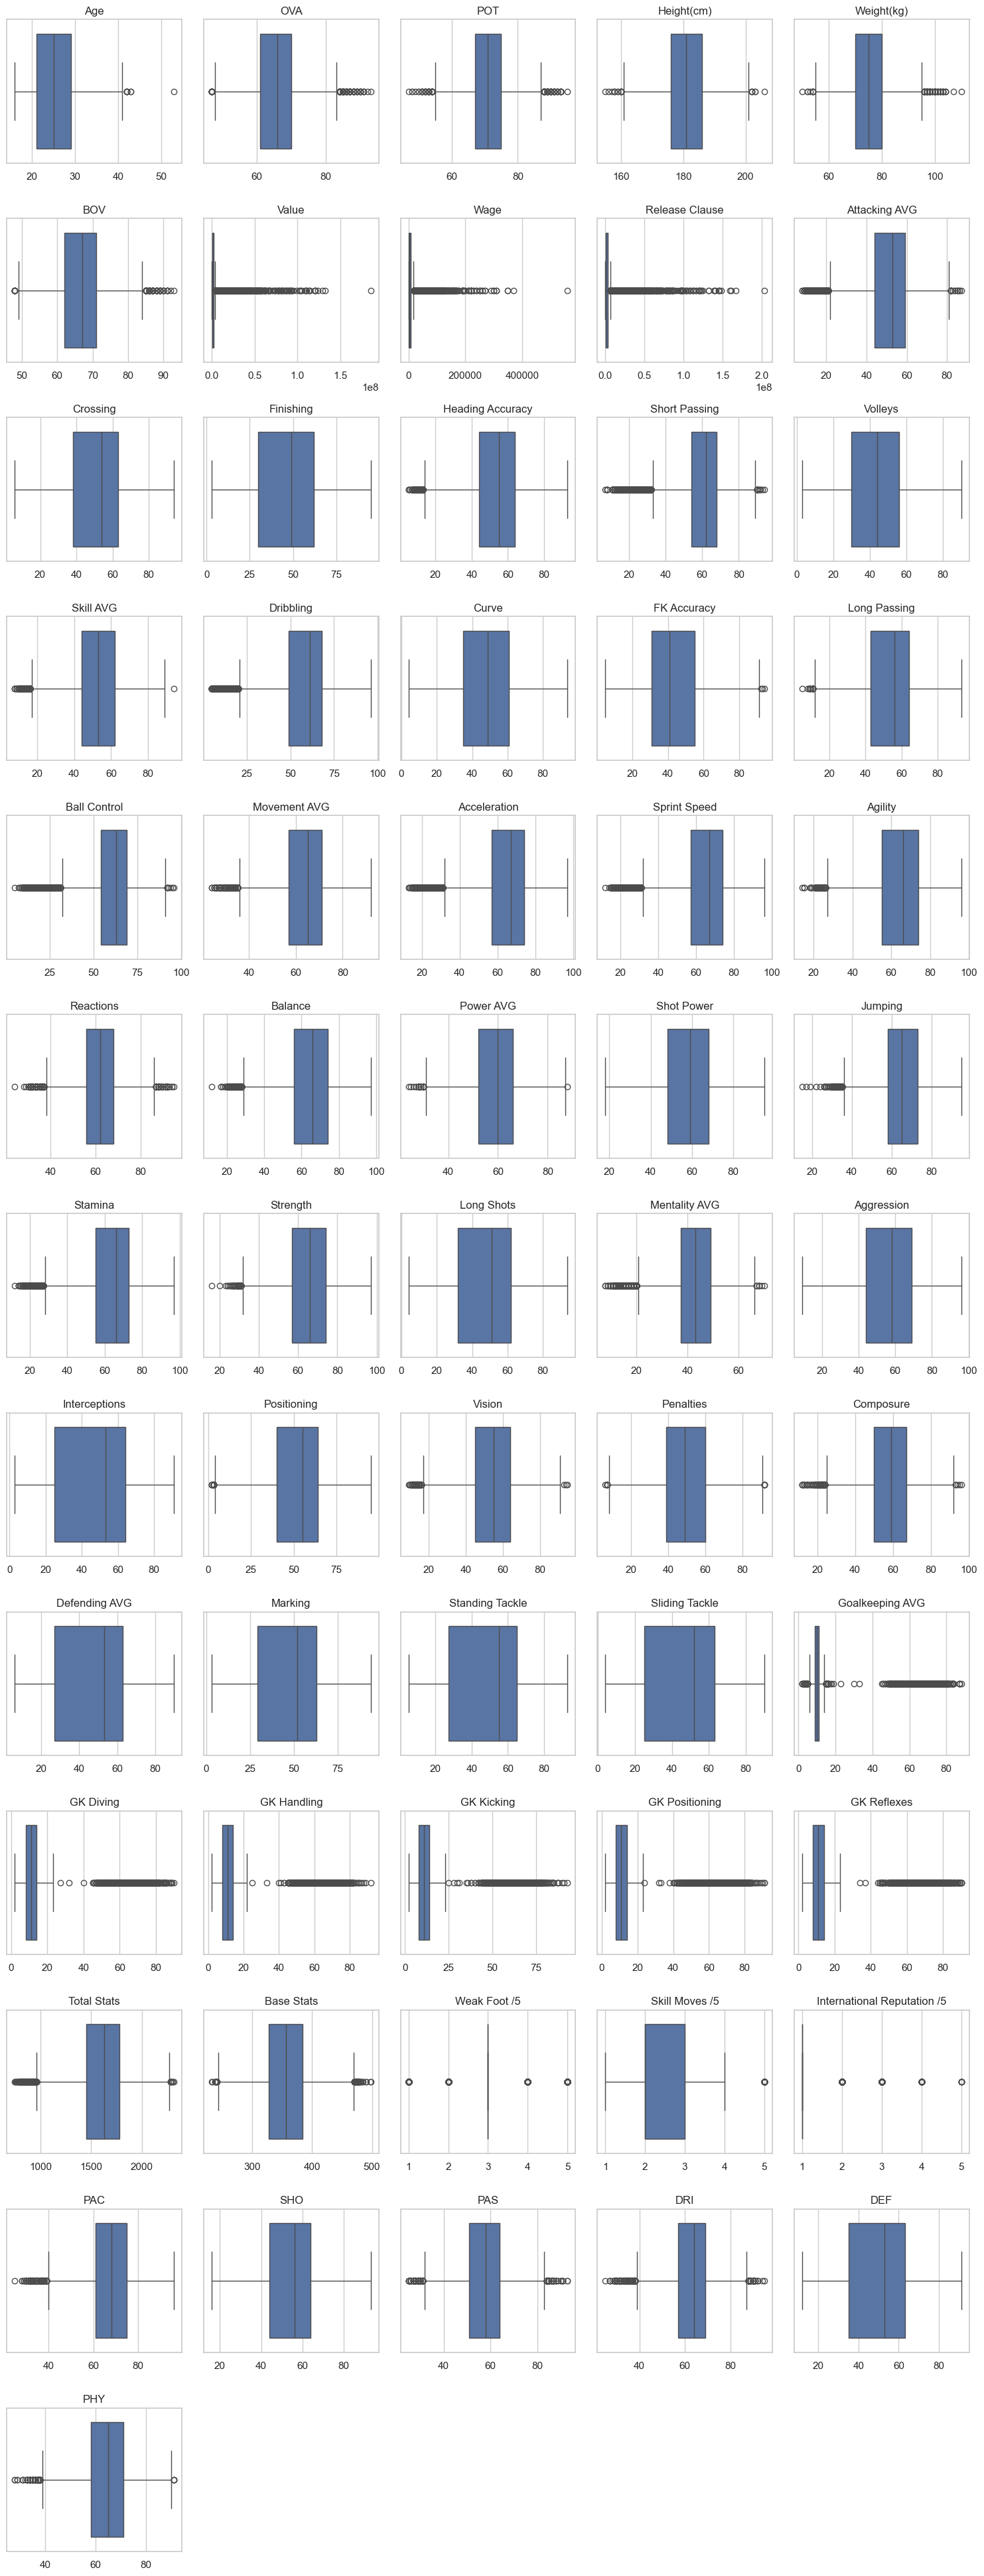

In [88]:
# Boxplot before outlier

sns.set(style="whitegrid")

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns #Selects only columns with numerical values

num_columns = 5 
num_rows = (len(numerical_columns) + num_columns - 1) // num_columns # Calculates number of rows (num_columns - 1 is there to account for the remainder

plt.figure(figsize=(num_columns * 3, num_rows * 3)) # I guess this is so there's room for each figure to take up 3*3 space

for i, column in enumerate(numerical_columns, 1): #Creates a value (column), and an index number for each value in the loop.
    plt.subplot(num_rows, num_columns, i) # with the given number of rows and columns, and the index i, it knows now where to put the chart
    sns.boxplot(x=df[column]) #Creates a boxplot of the values in the current column for each loop.
    plt.title(column) #Gives it a title of column
    plt.xlabel('') # No space, so gives it no value. 

plt.tight_layout()
plt.show()

# Explaining enumerate

Normally, when looping through an iterable, only the values are accessed. Enumerate creates pairs of count and element, instead of just the element (like an ID# for each one). i becomes the index number, and the var name (column) becomes the value. So it does this for the numerical_columns list, and gives the first index a value of one, as matplotlib uses index-1, not 0.

'i, column' are the two values being enumerated. First the index, then the value.

# Handling outliers

In [93]:
df_outliers = df.copy()

In [95]:
def handle_outliers_iqr(df_outliers, multiplier=1.5):
    numerical_columns = df_outliers.select_dtypes(include=['float64', 'int64']).columns

    for column in numerical_columns:
        Q1 = df_outliers[column].quantile(0.25)
        Q3 = df_outliers[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        outliers = df_outliers[(df_outliers[column] < lower_bound) | (df_outliers[column] > upper_bound)]
        #print(f"Outliers detected in '{column}': {outliers.index.tolist()}")

        df_outliers[column] = np.where(df_outliers[column] < lower_bound, lower_bound, df_outliers[column])
        df_outliers[column] = np.where(df_outliers[column] > upper_bound, upper_bound, df_outliers[column])

    return df_outliers

df_outliers = handle_outliers_iqr(df_outliers, multiplier=1.5)

for column in df_outliers.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df_outliers[column].quantile(0.25)
    Q3 = df_outliers[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    remaining_outliers = df_outliers[(df_outliers[column] < lower_bound) | (df_outliers[column] > upper_bound)]
    if not remaining_outliers.empty:
        print(f"Remaining outliers in '{column}': {remaining_outliers.index.tolist()}")
    else:
        print(f"No remaining outliers in '{column}'.")

No remaining outliers in 'Age'.
No remaining outliers in 'OVA'.
No remaining outliers in 'POT'.
No remaining outliers in 'Height(cm)'.
No remaining outliers in 'Weight(kg)'.
No remaining outliers in 'BOV'.
No remaining outliers in 'Value'.
No remaining outliers in 'Wage'.
No remaining outliers in 'Release Clause'.
No remaining outliers in 'Attacking AVG'.
No remaining outliers in 'Crossing'.
No remaining outliers in 'Finishing'.
No remaining outliers in 'Heading Accuracy'.
No remaining outliers in 'Short Passing'.
No remaining outliers in 'Volleys'.
No remaining outliers in 'Skill AVG'.
No remaining outliers in 'Dribbling'.
No remaining outliers in 'Curve'.
No remaining outliers in 'FK Accuracy'.
No remaining outliers in 'Long Passing'.
No remaining outliers in 'Ball Control'.
No remaining outliers in 'Movement AVG'.
No remaining outliers in 'Acceleration'.
No remaining outliers in 'Sprint Speed'.
No remaining outliers in 'Agility'.
No remaining outliers in 'Reactions'.
No remaining ou

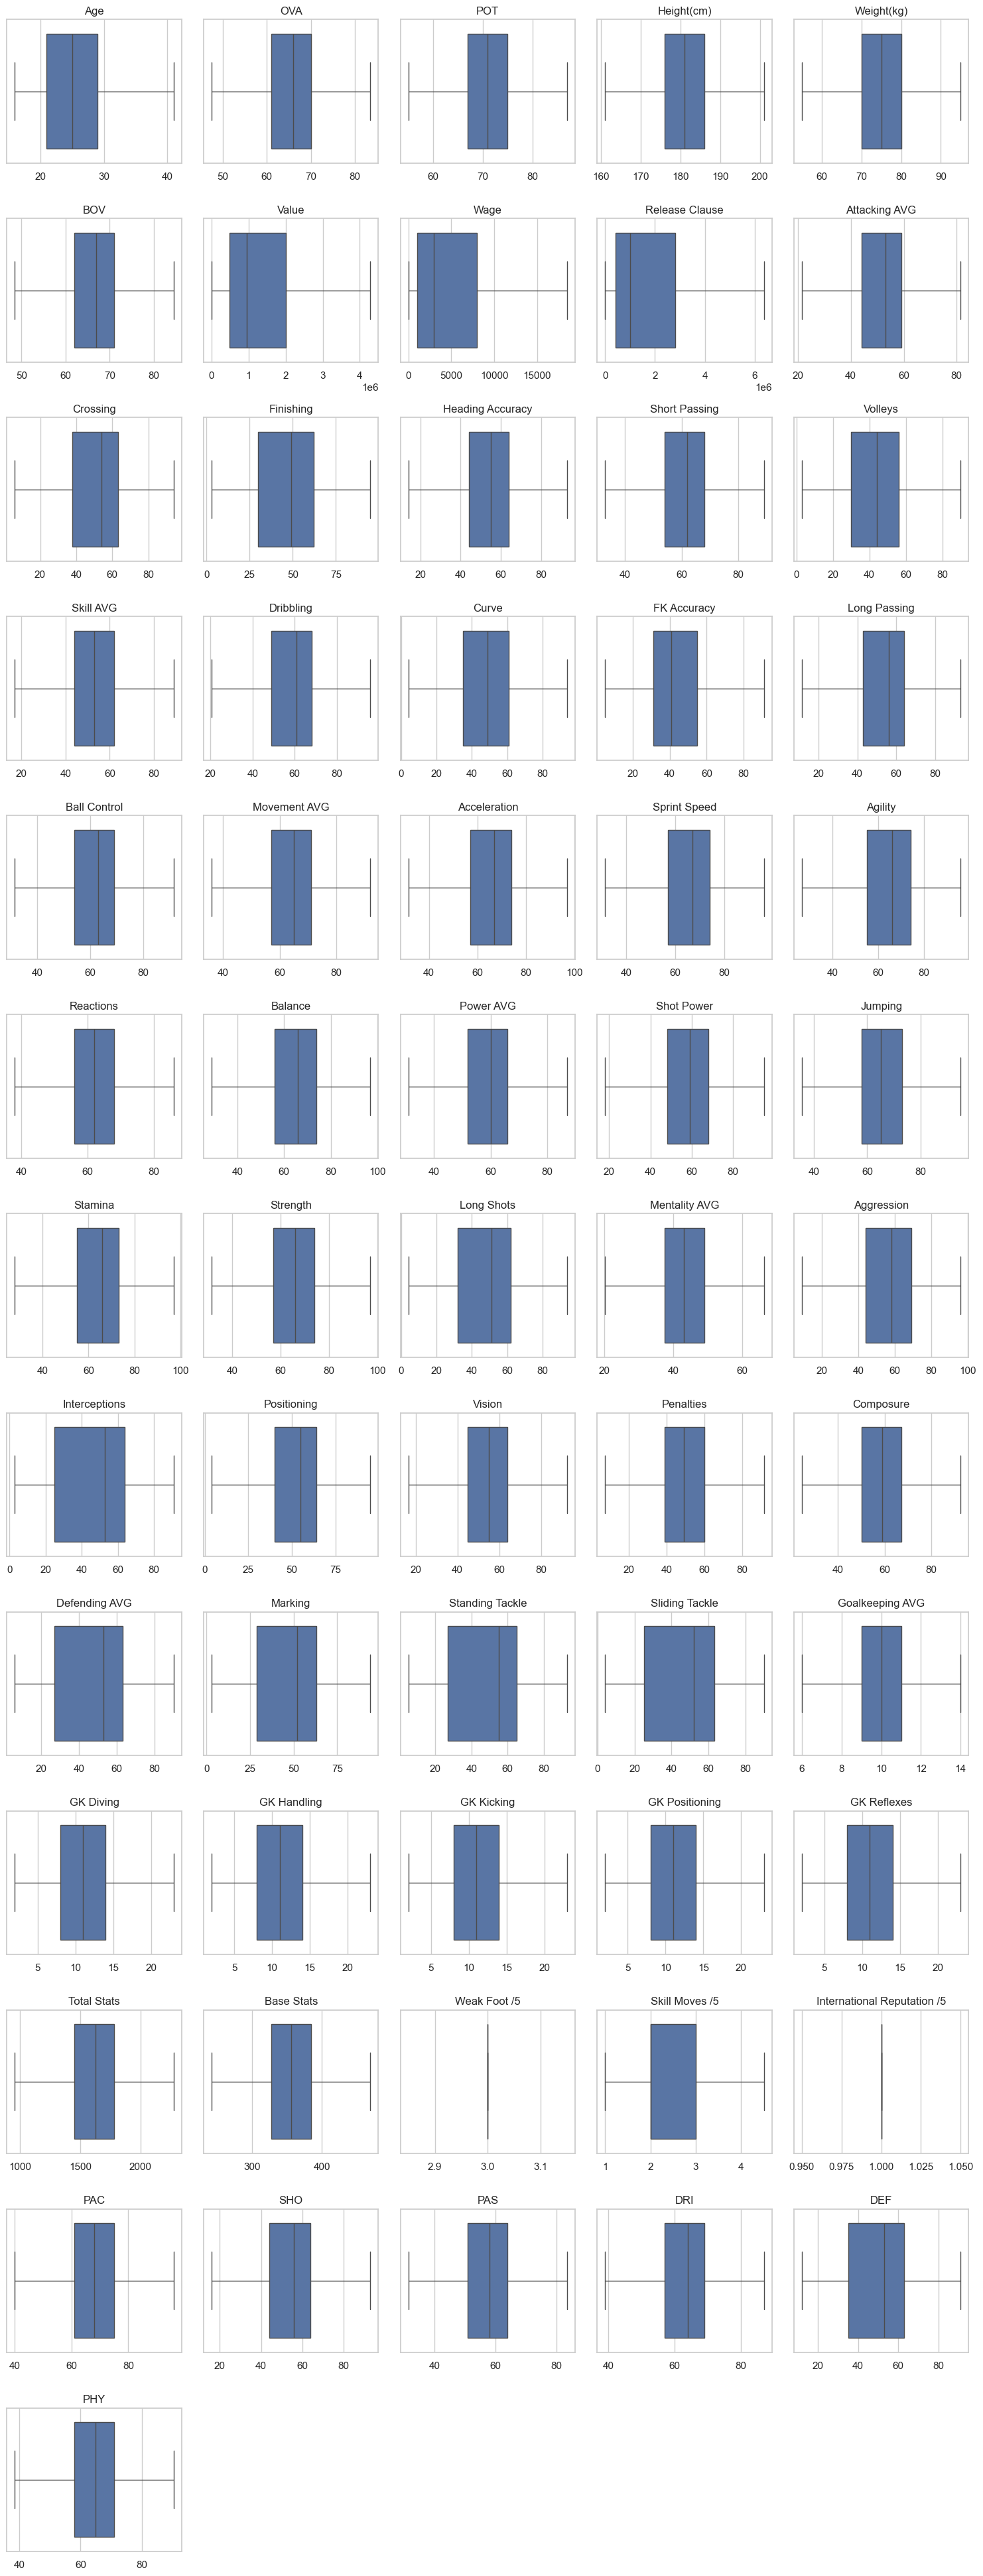

In [99]:
sns.set(style="whitegrid")

numerical_columns = df_outliers.select_dtypes(include=['float64', 'int64']).columns #Selects only columns with numerical values

num_columns = 5 
num_rows = (len(numerical_columns) + num_columns - 1) // num_columns # Calculates number of rows (num_columns - 1 is there to account for the remainder

plt.figure(figsize=(num_columns * 3, num_rows * 3)) # I guess this is so there's room for each figure to take up 3*3 space

for i, column in enumerate(numerical_columns, 1): #Creates a value (column), and an index number for each value in the loop.
    plt.subplot(num_rows, num_columns, i) # with the given number of rows and columns, and the index i, it knows now where to put the chart
    sns.boxplot(x=df_outliers[column]) #Creates a boxplot of the values in the current column for each loop.
    plt.title(column) #Gives it a title of column
    plt.xlabel('') # No space, so gives it no value. 

plt.tight_layout()
plt.show()